In [3]:
import xarray as xr
import numpy as np
import time
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [4]:
ds = xr.open_dataset('ocean_sta.nc').sel(ocean_time=slice('2011-01-01', '2014-01-01'), station=13)

In [51]:
ds

<xarray.Dataset>
Dimensions:             (tracer: 12, boundary: 4, s_rho: 40, s_w: 41,
                         ocean_time: 8760)
Coordinates:
  * s_rho               (s_rho) float64 -0.9875 -0.9625 ... -0.0375 -0.0125
  * s_w                 (s_w) float64 -1.0 -0.975 -0.95 ... -0.05 -0.025 0.0
    lon_rho             float64 ...
    lat_rho             float64 ...
  * ocean_time          (ocean_time) datetime64[ns] 2012-01-01 ... 2012-12-30...
Dimensions without coordinates: tracer, boundary
Data variables: (12/104)
    ntimes              int32 ...
    ndtfast             int32 ...
    dt                  float64 ...
    dtfast              float64 ...
    dstart              datetime64[ns] ...
    nHIS                int32 ...
    ...                  ...
    vice                (ocean_time) float32 ...
    aice                (ocean_time) float32 ...
    hice                (ocean_time) float32 ...
    tisrf               (ocean_time) float32 ...
    snow_thick          (ocean_time) float32 ...
    ti                  (ocean_time) float32 ...
Attributes: (12/45)
    file:              ocean_sta.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS station file
    title:             A20_v2j
    var_info:          varinfo_a20_v3_fabm_oxydep.dat
    ...                ...
    compiler_flags:    -mcmodel=large -xHOST -ip -O3 -free -free
    tiling:            008x016
    history:           ROMS/TOMS, Version 3.7, Wednesday - March 8, 2023 -  3...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    bio_file:          ROMS/Nonlinear/Biology/rfabm.h
    CPP_options:       a20_v3_oxydep, ADD_FSOBC, ADD_M2OBC, ALBEDO_CSIM, ALBE...

In [5]:
salt = ds['salt'].values
temp = ds['temp'].values
u = ds['u'].values
v = ds['v'].values
hice = ds['hice'].values
aice = ds['aice'].values
swrad = ds['swradWm2'].values

In [15]:
salt.shape

(26328, 40)

In [65]:
depth = -ds.h * (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
depth = depth.values[::-1]

In [68]:
ocean_time = ds['ocean_time'].values.astype('datetime64[s]')

In [69]:
ocean_time

array(['2011-01-01T00:00:00', '2011-01-01T01:00:00',
       '2011-01-01T02:00:00', ..., '2014-01-01T21:00:00',
       '2014-01-01T22:00:00', '2014-01-01T23:00:00'],
      dtype='datetime64[s]')

In [70]:
nh = salt.shape[0]
nz = salt.shape[1]

In [71]:
eair = np.zeros_like(temp[:,0])
kz = np.zeros_like(temp)

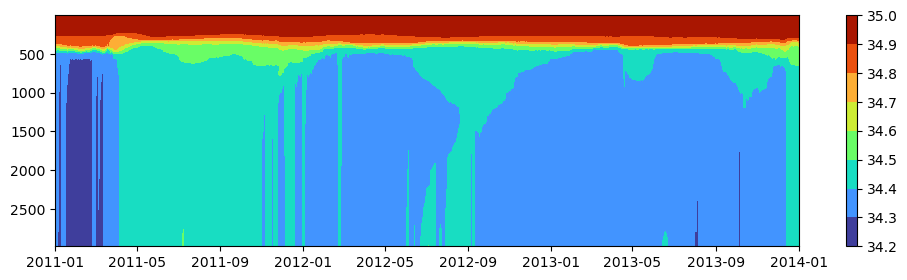

In [72]:
fig,ax = plt.subplots(figsize=(12,3))
plt.contourf(ocean_time, depth, salt.T, cmap='turbo')
plt.colorbar()
plt.gca().invert_yaxis()

In [73]:
# !!! WITHOUT Z-INTERPOLATION !!!
filename_out = 'RT_brom3.nc'
f_out = Dataset(filename_out, mode='w', format="NETCDF3_CLASSIC")
f_out.title = "Hydrophysics forcing file used for forcing the BROM model"
f_out.description = "Created for grid file:"
f_out.grd_file = "Gridfile: "
f_out.history = "Created " + time.ctime(time.time())
f_out.source = "Evgeniy Yakushev ()"
f_out.type = "File in format created using MODEL2BROM"
f_out.link = "https://github.com/trondkr/model2roms"
f_out.Conventions = "CF-1.0"

#-------- Define dimensions -----------------
f_out.createDimension('depth', nz)
f_out.createDimension('time', nh)
print("dim time: {} depth: {}".format(nh, nz))
fill_value=-32767.

#-------- create 1D DEPTH[:] ---------
v_depth = f_out.createVariable('depth', 'f', ('depth',),fill_value=fill_value)
v_depth.long_name = "depth"
v_depth.field = "depth, scalar, series"
v_depth.missing_value = fill_value
v_depth[:] = -depth  # !!! MINUS HERE !!!

#-------- creat 1D TIME DEPENDENT[:] ---------
#time[:]=fill_value
v_time = f_out.createVariable('oc_time', 'f', ('time',),fill_value=fill_value)
v_time.long_name = "oc_time"
v_time.field = "oc_time, scalar, series"
v_time.missing_value = fill_value
v_time[:] = ocean_time

v_hice = f_out.createVariable('hice', 'f', ('time',),fill_value=fill_value)
v_hice.long_name = "hice"
v_hice.time = "ocean_time"
v_hice.field = "hice, scalar, series"
v_hice.missing_value = fill_value
v_hice[:] = hice

v_aice = f_out.createVariable('aice', 'f', ('time',),fill_value=fill_value)
v_aice.long_name = "aice"
v_aice.time = "ocean_time"
v_aice.field = "aice, scalar, series"
v_aice.missing_value = fill_value
v_aice[:] = aice

v_swrad = f_out.createVariable('swradWm2', 'f', ('time',),fill_value=fill_value)
v_swrad.long_name = "swradWm2"
v_swrad.time = "ocean_time"
v_swrad.field = "swradWm2, scalar, series"
v_swrad.missing_value = fill_value
v_swrad[:] = swrad

eair[:]=fill_value
v_eair = f_out.createVariable('eair', 'f', ('time',),fill_value=fill_value)
v_eair.long_name = "eair"
v_eair.field = "eair, scalar, series"
v_eair.missing_value = fill_value
v_eair[:] = eair

#-------- creat 2D VARIABLES[:,:] at DEPTH[:] ---------
v_salt = f_out.createVariable('salt', 'f', ('depth', 'time',),fill_value=fill_value)
v_salt.long_name = "salinity"
v_salt.time = "ocean_time"
v_salt.field = "salinity, scalar, series"
v_salt.missing_value = fill_value
v_salt[:]=np.flip(salt.T, axis=0)

v_temp = f_out.createVariable('temp', 'f', ('depth', 'time',),fill_value=fill_value)
v_temp.long_name = "temperature"
v_temp.time = "ocean_time"
v_temp.field = "temperature, scalar, series"
v_temp.missing_value = fill_value
v_temp[:]=np.flip(temp.T, axis=0)

v_u = f_out.createVariable('u', 'f', ('depth', 'time',),fill_value=fill_value)
v_u.long_name = "u"
v_u.time = "ocean_time"
v_u.field = "u, scalar, series"
v_u.missing_value = fill_value
v_u[:] = np.flip(u.T, axis=0)

v_v = f_out.createVariable('v', 'f', ('depth', 'time',),fill_value=fill_value)
v_v.long_name = "v"
v_v.time = "ocean_time"
v_v.field = "v, scalar, series"
v_v.missing_value = fill_value
v_v[:] = np.flip(v.T, axis=0)

v_Kz = f_out.createVariable('Kz', 'f', ('depth', 'time',),fill_value=fill_value)
v_Kz.long_name = "Kz"
v_Kz.time = "ocean_time"
v_Kz.field = "Kz, scalar, series"
v_Kz.missing_value = fill_value
v_Kz[:] = np.flip(kz.T, axis=0)

f_out.close()

dim time: 26328 depth: 40


In [24]:
# !!! WITHOUT Z-INTERPOLATION !!!
filename_out = 'Laptev_brom.nc'
f_out = Dataset(filename_out, mode='w', format="NETCDF3_CLASSIC")
f_out.title = "Hydrophysics forcing file used for forcing the BROM model"
f_out.description = "Created for grid file:"
f_out.grd_file = "Gridfile: "
f_out.history = "Created " + time.ctime(time.time())
f_out.source = "Evgeniy Yakushev ()"
f_out.type = "File in format created using MODEL2BROM"
f_out.link = "https://github.com/trondkr/model2roms"
f_out.Conventions = "CF-1.0"

#-------- Define dimensions -----------------
f_out.createDimension('depth', nz)
f_out.createDimension('time', nh)
print("dim time: {} depth: {}".format(nh, nz))
fill_value=-32767.

#-------- create 1D DEPTH[:] ---------
v_depth = f_out.createVariable('depth', 'f', ('depth',),fill_value=fill_value)
v_depth.long_name = "depth"
v_depth.field = "depth, scalar, series"
v_depth.missing_value = fill_value
v_depth[:] = -depth  # !!! MINUS HERE !!!

#-------- creat 1D TIME DEPENDENT[:] ---------
#time[:]=fill_value
v_time = f_out.createVariable('oc_time', 'f', ('time',),fill_value=fill_value)
v_time.long_name = "oc_time"
v_time.field = "oc_time, scalar, series"
v_time.missing_value = fill_value
v_time[:] = ocean_time

v_hice = f_out.createVariable('hice', 'f', ('time',),fill_value=fill_value)
v_hice.long_name = "hice"
v_hice.time = "ocean_time"
v_hice.field = "hice, scalar, series"
v_hice.missing_value = fill_value
v_hice[:] = hice

v_aice = f_out.createVariable('aice', 'f', ('time',),fill_value=fill_value)
v_aice.long_name = "aice"
v_aice.time = "ocean_time"
v_aice.field = "aice, scalar, series"
v_aice.missing_value = fill_value
v_aice[:] = aice

v_swrad = f_out.createVariable('swradWm2', 'f', ('time',),fill_value=fill_value)
v_swrad.long_name = "swradWm2"
v_swrad.time = "ocean_time"
v_swrad.field = "swradWm2, scalar, series"
v_swrad.missing_value = fill_value
v_swrad[:] = swrad

eair[:]=fill_value
v_eair = f_out.createVariable('eair', 'f', ('time',),fill_value=fill_value)
v_eair.long_name = "eair"
v_eair.field = "eair, scalar, series"
v_eair.missing_value = fill_value
v_eair[:] = eair

#-------- creat 2D VARIABLES[:,:] at DEPTH[:] ---------
v_salt = f_out.createVariable('salt', 'f', ('depth', 'time',),fill_value=fill_value)
v_salt.long_name = "salinity"
v_salt.time = "ocean_time"
v_salt.field = "salinity, scalar, series"
v_salt.missing_value = fill_value
v_salt[:]=salt.T

v_temp = f_out.createVariable('temp', 'f', ('depth', 'time',),fill_value=fill_value)
v_temp.long_name = "temperature"
v_temp.time = "ocean_time"
v_temp.field = "temperature, scalar, series"
v_temp.missing_value = fill_value
v_temp[:]=temp.T

v_u = f_out.createVariable('u', 'f', ('depth', 'time',),fill_value=fill_value)
v_u.long_name = "u"
v_u.time = "ocean_time"
v_u.field = "u, scalar, series"
v_u.missing_value = fill_value
v_u[:] = u.T

v_v = f_out.createVariable('v', 'f', ('depth', 'time',),fill_value=fill_value)
v_v.long_name = "v"
v_v.time = "ocean_time"
v_v.field = "v, scalar, series"
v_v.missing_value = fill_value
v_v[:] = v.T

v_Kz = f_out.createVariable('Kz', 'f', ('depth', 'time',),fill_value=fill_value)
v_Kz.long_name = "Kz"
v_Kz.time = "ocean_time"
v_Kz.field = "Kz, scalar, series"
v_Kz.missing_value = fill_value
v_Kz[:] = kz.T

f_out.close()

dim time: 8760 depth: 40


In [48]:
out = xr.open_dataset('RT_brom3.nc')

In [49]:
out

<xarray.Dataset>
Dimensions:   (depth: 40, time: 26328)
Coordinates:
  * depth     (depth) float32 -2.922 -8.9 -15.06 ... -2.552e+03 -2.984e+03
Dimensions without coordinates: time
Data variables:
    oc_time   (time) float32 ...
    hice      (time) float32 ...
    aice      (time) float32 ...
    swradWm2  (time) float32 ...
    eair      (time) float32 ...
    salt      (depth, time) float32 ...
    temp      (depth, time) float32 ...
    u         (depth, time) float32 ...
    v         (depth, time) float32 ...
    Kz        (depth, time) float32 ...
Attributes:
    title:        Hydrophysics forcing file used for forcing the BROM model
    description:  Created for grid file:
    grd_file:     Gridfile: 
    history:      Created Tue Dec 12 11:00:14 2023
    source:       Evgeniy Yakushev ()
    type:         File in format created using MODEL2BROM
    link:         https://github.com/trondkr/model2roms
    Conventions:  CF-1.0